<a href="https://colab.research.google.com/github/JibrilEl/Temperature-forecasting/blob/main/temperature_treatement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-Imports and data exploration

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("city_temperature.csv")
print(df.head())

   Month  Day  Year  AvgTemperature
0      1    1  1995            64.2
1      1    2  1995            49.4
2      1    3  1995            48.8
3      1    4  1995            46.4
4      1    5  1995            47.9


In [ ]:
#We only keep the temperatures as we are not interested in other values
temperatures = df['AvgTemperature']
print(temperatures[:10])

0    64.2
1    49.4
2    48.8
3    46.4
4    47.9
5    48.7
6    48.9
7    49.1
8    49.0
9    51.9
Name: AvgTemperature, dtype: float64


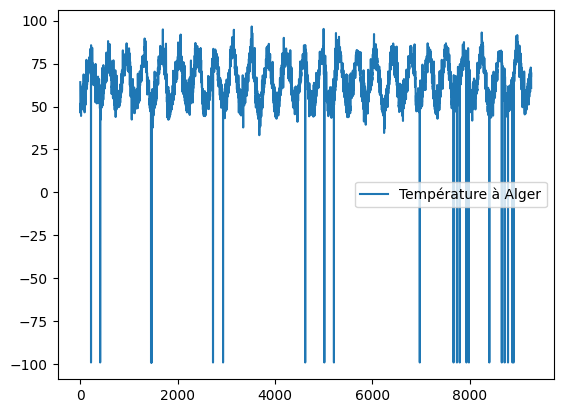

In [ ]:
day = [ i for i in range(len(temperatures))]
plt.plot(day,temperatures, label="Température à Alger")
plt.legend()
plt.show()

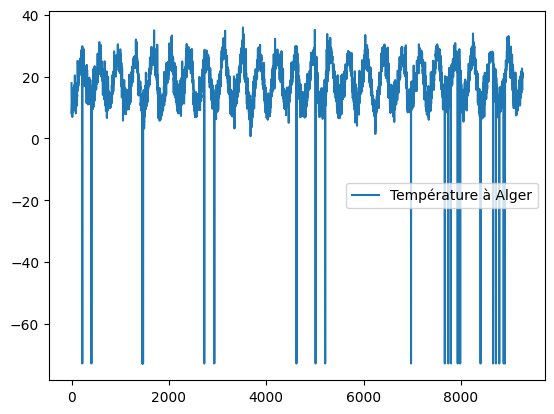

In [ ]:
#We convert the value into celsius
temperatures = [((x-32)*5)/9 for x in temperatures]
plt.plot(day,temperatures, label="Température à Alger")
plt.legend()
plt.show()

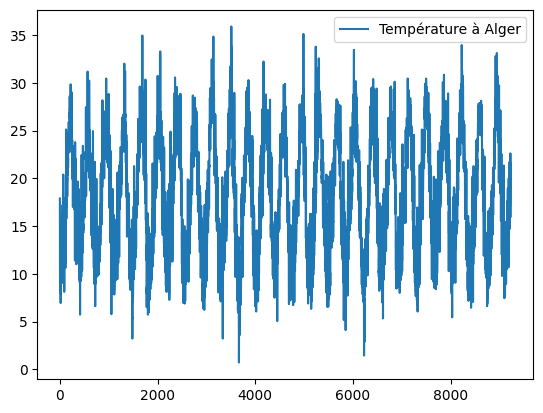

In [ ]:
#Getting rid of the outliers
temperatures = [x for x in temperatures if x>-20]
day = [ i for i in range(len(temperatures))]
plt.plot(day,temperatures, label="Température à Alger")
plt.legend()
plt.show()

In [ ]:
#I will train models on raw temperature and on a moving average, this treatement is for raw temperatures
#We ssplit into training and validation set
len_train = int(len(temperatures)*0.85)
temperatures_train = temperatures[:len_train]
temperatures_val = temperatures[len_train:]

In [ ]:

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor="val_loss",patience = 20)
treated_temp_train = []
etiquette_train = []
context_length =15
#Creating windowed dataset for training. I choose arbitrarly a window size of 15
for i in range (len(temperatures_train)-context_length-1):
  treated_temp_train+=[temperatures_train[i:i+context_length]]
  etiquette_train+=[temperatures_train[i+context_length+1]]
treated_temp_val = []
etiquette_val=[]
#Doing the same for validation, we can factor this by doing it on the list before splitting
for i in range (len(temperatures_val)-context_length-1):
  treated_temp_val+=[temperatures_val[i:i+context_length]]
  etiquette_val+=[temperatures_val[i+context_length+1]]


In [ ]:
#Changing the shape because lstms require 3 dimensional arrays
treated_temp_val_array =np.array(treated_temp_val)
treated_temp_val_array = treated_temp_val_array.reshape(treated_temp_val_array.shape[0],context_length,1)
treated_temp_train_lstm = np.array(treated_temp_train).reshape(len(treated_temp_train),len(treated_temp_train[0]),1)
treated_temp_val_lstm= np.array(treated_temp_val).reshape(len(treated_temp_val),len(treated_temp_val[0]),1)
etiquette_train_lstm = np.array(etiquette_train).reshape(len(etiquette_train),1)
etiquette_val_lstm = np.array(etiquette_val).reshape(len(etiquette_val),1)
print(treated_temp_val_array.shape)
print(treated_temp_train_lstm.shape)
print(etiquette_train_lstm.shape)
print(treated_temp_val_lstm.shape)
print(etiquette_val_lstm.shape)
#Thos data can be used to train models. Yet, the temperature is very noisy and i wanted to investigate this more in depth

(1369, 15)
(1369, 15, 1)


In [ ]:
#Creating a function to compute mean absolute error. This function probably exists with numpy...
def mae(list1,list2):
  n=0
  mae=0
  if len(list1)>len(list2):
    n= len(list2)
  else:
    n=len(list1)
  for i in range(n):
    mae+=abs(list1[i]-list2[i])
  return(mae/n)

(9231,)
1.494962876699692


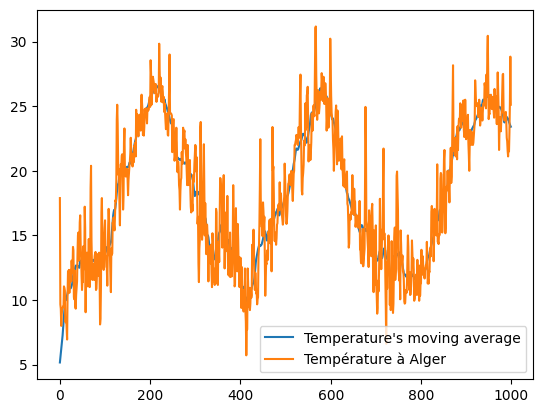

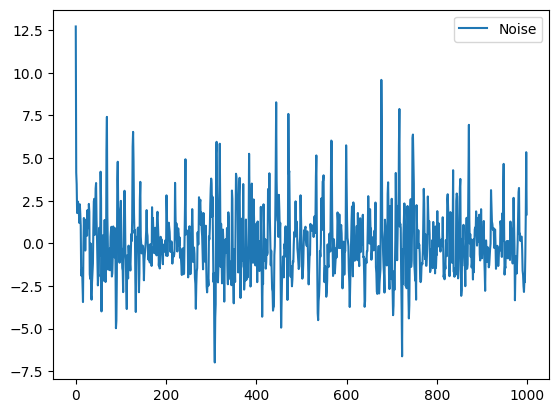

In [ ]:
#Creating a moving average to get rid of the noise
window_size = 24
half_window = window_size // 2
#Using convolution to create the moving average
mov_avg = np.convolve(temperatures, np.ones(window_size) / window_size, mode='same')
noise = temperatures - mov_avg
print(mov_avg.shape)
print(mae(mov_avg,temperatures))
#We see that the moving average has a mean absolute error of 1.5. It is an important value because it means that we probably
#won't be able to get a better precision. Indeed, by training on the noisy dataset, it was a limit
plt.plot(day[:1000], mov_avg[:1000], label="Temperature's moving average")
plt.plot(day[:1000], temperatures[:1000], label="Température à Alger")
plt.legend()
plt.show()
#Plotting the noise, we see that it looks completely random, I will check this hypothesis to look for improvement
plt.plot(day[:1000], noise[:1000], label="Noise")
plt.legend()
plt.show()

<Axes: ylabel='Count'>

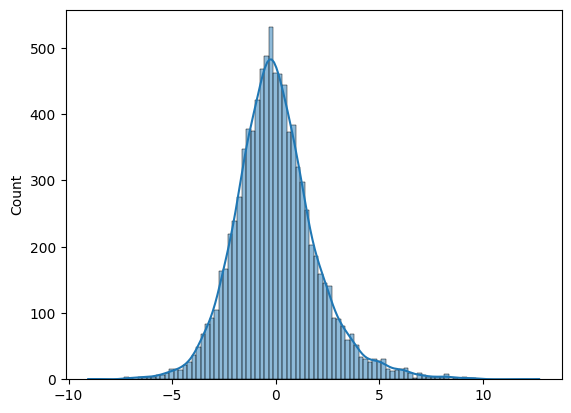

In [ ]:
sns.histplot(x=noise,kde=True)
#plotting the noise, it looks indeed like a Gaussian distribution

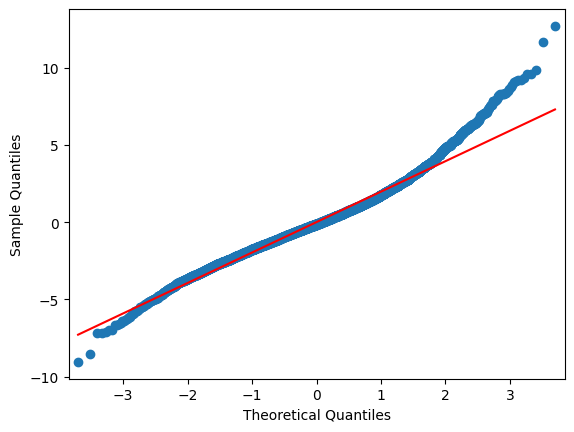

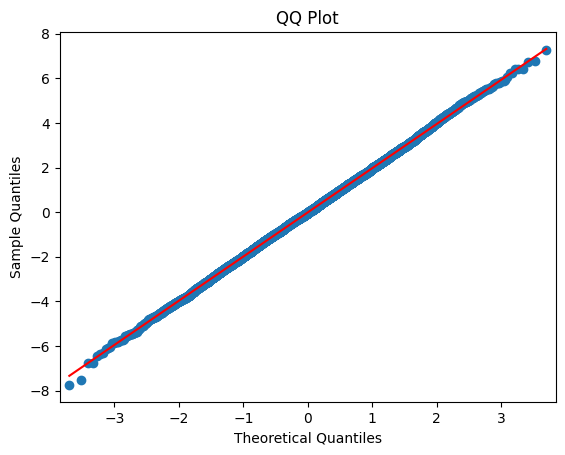

In [ ]:
import statsmodels.api as sm
#Using QQplot, I see that it not really gaussian, there are more high values
sm.qqplot(np.array(noise), line='r')
sm.qqplot(np.random.normal(loc=0, scale=2, size=len(bruit)), line='r')
plt.title('QQ Plot')
plt.show()

In [ ]:
noise_up =0
noise_down=0
for k in range(len(noise)):
  if noise[k]>5:
    noise_up+=1
  elif noise[k]<-5:
    noise_down+=1
print('noise up : '+ str(bruit_up/len(bruit)))
print('noise down : '+ str(bruit_down/len(bruit)))
#We check this hypothesis, indeed, the distribution is not really gaussian

noise up : 0.019824504387390314
noise down : 0.006066515003791572


In [ ]:
mean = 0
sigma=0
for i in range(len(bruit)):
  mean+=bruit[i]
mean=mean/len(bruit)
for k in range(len(bruit)):
  sigma+=(bruit[i]-mean)**2
sigma=(sigma/len(bruit))**(1/2)
print('Le bruit moyen est de : '+ str(mean))
print('L\'écart type est de : '+ str(sigma) )

Le bruit moyen est de : 0.010396369720386317
L'écart type est de : 5.349603630278989


In [ ]:
#I still created a training set to fit the moving average curve
mov_avg_train = []
etiquette_mov=[]
context_length = 15
for i in range (len(mov_avg)-context_length-1):
  mov_avg_train+=[mov_avg.tolist()[i-context_length:i]]
  etiquette_mov +=[mov_avg[i]]
for i in range(context_length):
  etiquette_mov.pop(0)
  mov_avg_train.pop(0)
print(mov_avg_train[0])
print(etiquette_mov[0])

[5.295555555555555, 5.626666666666666, 5.97111111111111, 6.280000000000001, 6.557777777777779, 6.9733333333333345, 7.462222222222223, 7.920000000000001, 8.413333333333334, 8.835555555555556, 9.313333333333334, 9.806666666666668, 10.300000000000002, 10.042222222222223, 10.17777777777778]
10.288888888888891


In [ ]:
#Spliitting to train
val_sep = int(0.85*len(mov_avg_train))
x_train = mov_avg_train[:val_sep]
x_val = mov_avg_train[val_sep:]
y_train = etiquette_mov[:val_sep]
y_val = etiquette_mov[val_sep:]
#x_val = np.array(x_val)
#x_val = x_val.reshape(x_val.shape[0],15,1)
#x_train = np.array(x_train)
#x_train = x_train.reshape(x_train.shape[0],15,1)
#print(x_train.shape)
#print(x_val.shape)

In [ ]:
#Training a basic model on the raw temperatures
np.random.seed(42)
tf.random.set_seed(42)
regression = tf.keras.models.Sequential()
regression.add(tf.keras.layers.Dense(1,activation = "linear"))
regression.compile(optimizer="adam", loss="huber",metrics=["mae"])
history =regression.fit(treated_temp_train,etiquette_train,validation_data=(treated_temp_val,etiquette_val),batch_size=32,epochs=150,callbacks=[early_stopping])
plt.plot(history.epoch,history.history["mae"],label = "Mean absolute error")
plt.plot(history.epoch,history.history["val_mae"],label = "Validation mean absolute error")
plt.legend()
plt.show()
plt.plot(history.epoch,history.history["loss"],label = "loss")
plt.plot(history.epoch,history.history["val_loss"],label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
#Checking predictions
print(len(regression.predict(treated_temp_val)))
plt.plot(regression.predict(treated_temp_val)[:500])
plt.plot(temperatures_val[:500])
plt.show()

In [ ]:
#Looking at weights
print(regression.get_weights())

In [ ]:
#I tried other models, such as bidirectional LSTM and WaveNet type CNN, none of them got lower than a validation MAE of
#1.5 which is the performance of the linear regression trained on the moving average
np.random.seed(42)
tf.random.set_seed(42)
bidi_lstm = tf.keras.models.Sequential()
bidi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,activation = "tanh",return_sequences=True)))
bidi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,activation = "tanh")))
bidi_lstm.add(tf.keras.layers.Dense(32,activation="relu"))
bidi_lstm.add(tf.keras.layers.Dense(1,activation ="linear"))

In [ ]:
def lr_schedule(epoch,lr):
  return(lr*(10**(epoch/30)))
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
#Learning rate scheduler
#np.random.seed(42)
#tf.random.set_seed(42)
#bidi_lstm.compile(optimizer=tf.keras.optimizers.Adam(1*10**-5), loss="huber",metrics=["mae"])
#history =bidi_lstm.fit(treated_temp_train_lstm,etiquette_train_lstm,validation_data=(treated_temp_val_lstm,etiquette_val_lstm),batch_size=128,epochs=25,callbacks=[learning_rate_scheduler])
#plt.plot(history.history["val_loss"])
#plt.show()

In [ ]:
bidi_lstm = tf.keras.models.Sequential()
bidi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,activation = "tanh",return_sequences=True)))
bidi_lstm.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50,activation = "tanh")))
bidi_lstm.add(tf.keras.layers.Dense(32,activation="relu"))
bidi_lstm.add(tf.keras.layers.Dense(1,activation ="linear"))

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
bidi_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0016), loss="mse",metrics=["mae"])
history =bidi_lstm.fit(treated_temp_train_lstm,etiquette_train_lstm,validation_data=(treated_temp_val_lstm,etiquette_val_lstm),batch_size=128,epochs=200, callbacks =[early_stopping])
plt.plot(history.epoch,history.history["mae"],label = "Mean absolute error")
plt.plot(history.epoch,history.history["val_mae"],label = "Validation mean absolute error")
plt.legend()
plt.show()
plt.plot(history.epoch,history.history["loss"],label = "loss")
plt.plot(history.epoch,history.history["val_loss"],label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(bidi_lstm.predict(treated_temp_val_array)[:1000])
plt.plot(temperatures_val[:1000])
plt.show()

In [ ]:
weave_net = tf.keras.models.Sequential()
weave_net.add(tf.keras.layers.Conv1D(64,activation='relu',kernel_size=15,dilation_rate=1,padding ='causal',input_shape=(365,1), ))
weave_net.add(tf.keras.layers.BatchNormalization())
weave_net.add(tf.keras.layers.Conv1D(64,activation='relu',kernel_size=15,dilation_rate=2,padding ='causal',))
weave_net.add(tf.keras.layers.BatchNormalization())
weave_net.add(tf.keras.layers.Conv1D(64,activation='relu',kernel_size=15,dilation_rate=8,padding='causal',))
weave_net.add(tf.keras.layers.BatchNormalization())
weave_net.add(tf.keras.layers.Conv1D(32,activation='relu',kernel_size=15,dilation_rate=16,padding ='causal',))
weave_net.add(tf.keras.layers.BatchNormalization())
weave_net.add(tf.keras.layers.Conv1D(32,activation='relu',kernel_size=15,dilation_rate=64,padding='causal',))
weave_net.add(tf.keras.layers.BatchNormalization())
weave_net.add(tf.keras.layers.Conv1D(32,activation='relu',kernel_size=15,dilation_rate=128,padding='causal'))
weave_net.add(tf.keras.layers.BatchNormalization())
weave_net.add(tf.keras.layers.GlobalAveragePooling1D())
weave_net.add(tf.keras.layers.Dropout(0.5))
weave_net.add(tf.keras.layers.Dense(128,activation='relu'))
weave_net.add(tf.keras.layers.Dense(1,activation ='linear'))
print(weave_net.summary())

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
weave_net.compile(optimizer=tf.keras.optimizers.Adam(1*10**-5), loss="mse",metrics=["mae"])
history =weave_net.fit(treated_temp_train_lstm,etiquette_train_lstm,validation_data=(treated_temp_val_lstm,etiquette_val_lstm),batch_size=128,epochs=25,callbacks=[learning_rate_scheduler])
plt.plot(history.history["val_loss"])
plt.show()

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
weave_net.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000100), loss="huber",metrics=["mae"])
history =weave_net.fit(treated_temp_train_lstm,etiquette_train_lstm,validation_data=(treated_temp_val_lstm,etiquette_val_lstm),batch_size=800,epochs=200, callbacks =[early_stopping])
plt.plot(history.epoch,history.history["mae"],label = "Mean absolute error")
plt.plot(history.epoch,history.history["val_mae"],label = "Validation mean absolute error")
plt.legend()
plt.show()
plt.plot(history.epoch,history.history["loss"],label = "loss")
plt.plot(history.epoch,history.history["val_loss"],label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(weave_net.predict(treated_temp_val_array)[:1000],label='prediction')
plt.plot(temperatures_val[:1000],label='real')
plt.legend()
plt.show()

In [ ]:
dnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=16, kernel_size=365,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=(365,1)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='relu')),
    tf.keras.layers.Dense(16,activation='relu'),
    tf.keras.layers.Dense(1, activation = 'linear')
])
print(dnn_model.summary())

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)
dnn_model.compile(optimizer='adam', loss="huber",metrics=["mae"])
history =dnn_model.fit(treated_temp_train_lstm,etiquette_train_lstm,validation_data=(treated_temp_val_lstm,etiquette_val_lstm),batch_size=200,epochs=200, callbacks =[early_stopping])
plt.plot(history.epoch,history.history["mae"],label = "Mean absolute error")
plt.plot(history.epoch,history.history["val_mae"],label = "Validation mean absolute error")
plt.legend()
plt.show()
plt.plot(history.epoch,history.history["loss"],label = "loss")
plt.plot(history.epoch,history.history["val_loss"],label = "Validation loss")
plt.legend()
plt.show()

In [ ]:
plt.plot(dnn_model.predict(treated_temp_val_array)[:500],label='prediction')
plt.plot(temperatures_val[:500],label='real')
plt.legend()
plt.show()

In [ ]:
import xgboost as xgb
xgbr=xgb.XGBRegressor(booster="dart",objective="reg:squarederror",n_estimators=151)
xgbr.fit(treated_temp_train,etiquette_train)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=151, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgbrpred = xgbr.predict(treated_temp_val)
plt.plot(xgbrpred[:500],label='prediction')
plt.plot(temperatures_val[:500],label='real')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error
print("Mean Squared Error (MSE) score XGBoost:"+str(mean_absolute_error(etiquette_val,xgbrpred)))

Mean Squared Error (MSE) score XGBoost:1.6873170346031399


In [ ]:
plt.plot(day[:1000],temperatures[:1000], label="Température à Alger")
plt.legend()
plt.show()

In [ ]:
#Now training on moving average, we see that we can predict it extremely accurately,
#know that the moving average has a mae of 1.5, we get to an mae of 1.58 with a linear regression
#I'm sure we can do better
np.random.seed(42)
tf.random.set_seed(42)
regression = tf.keras.models.Sequential()
regression.add(tf.keras.layers.Dense(1,activation = "linear"))
regression.compile(optimizer="adam", loss="huber",metrics=["mae"])
history =regression.fit(x_train,y_train,validation_data=(x_val,y_val),batch_size=32,epochs=70,callbacks=[early_stopping])
plt.plot(history.epoch,history.history["mae"],label = "Mean absolute error")
plt.plot(history.epoch,history.history["val_mae"],label = "Validation mean absolute error")
plt.legend()
plt.show()
plt.plot(history.epoch,history.history["loss"],label = "loss")
plt.plot(history.epoch,history.history["val_loss"],label = "Validation loss")
plt.legend()
plt.show()

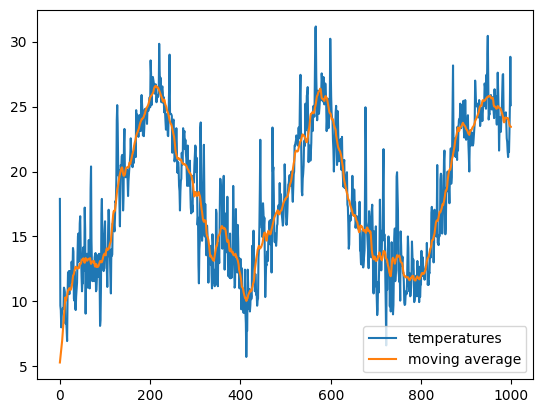

In [ ]:
#mov_avg = [temperatures[0] for i in range(window_size//2)] + mov_avg
plt.plot(temperatures[:1000],label="temperatures")
plt.plot(mov_avg[:1000],label="moving average")
plt.legend()
plt.show()

In [ ]:
#Looking for ways to improve the model, leave ideas in the comment or implement it yourself !